In [1]:
from fastai import *
from fastai.vision import *
import torch.onnx
from torch.autograd import Variable

import netron

In [2]:
import os

os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

In [3]:
path = untar_data(URLs.CIFAR_100)

In [4]:
data = (
    (
        ImageList.from_folder(path)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(get_transforms(), size=128)
    )
    .databunch(bs=64)
    .normalize(imagenet_stats)
)

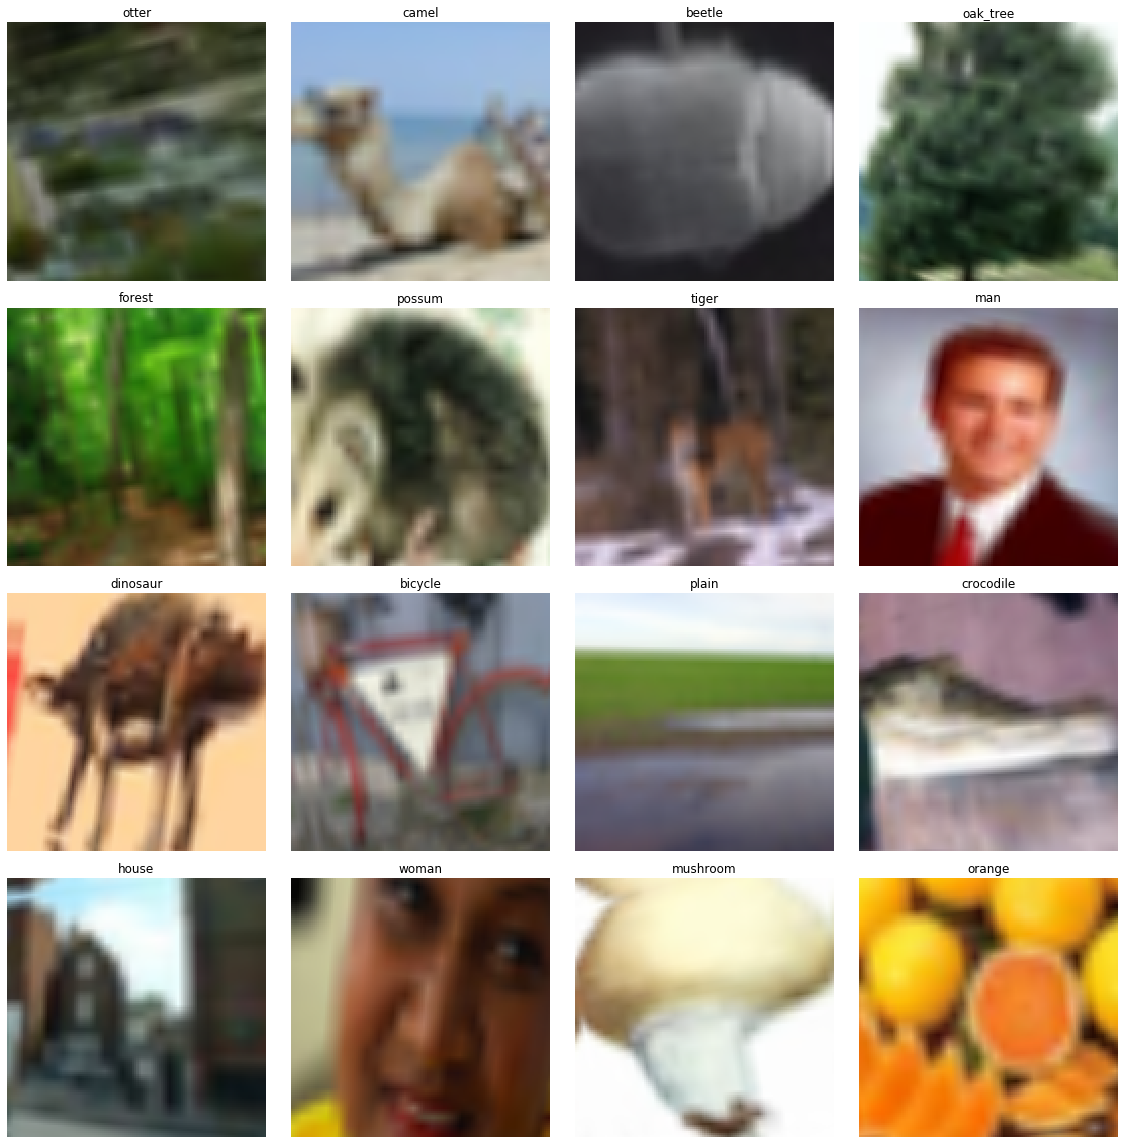

In [5]:
data.show_batch(4)

In [6]:
data.c

100

In [7]:
data

ImageDataBunch;

Train: LabelList (48000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
cloud,cloud,cloud,cloud,cloud
Path: /home/subhaditya/.fastai/data/cifar100;

Valid: LabelList (12000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
turtle,flatfish,palm_tree,otter,tractor
Path: /home/subhaditya/.fastai/data/cifar100;

Test: None

# Mobile Net

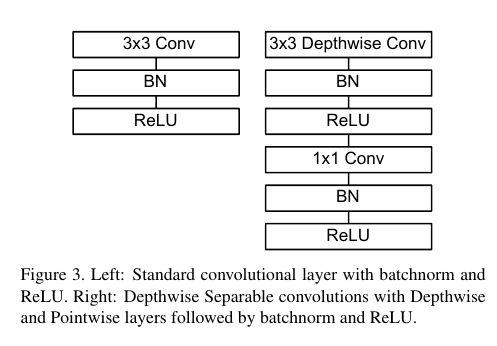

In [81]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        self.lin1 = nn.Linear(1024, 100)
        self.convn = nn.Sequential(  # depthwise when changing from a smaller to bigger layer
            self.conv_block(32, 64, 1),
            self.conv_block(64, 128, 2),
            self.conv_block(128, 128, 1),
            self.conv_block(128, 256, 2),
            self.conv_block(256, 256, 1),
            self.conv_block(256, 512, 2),
            self.conv_block(512, 512, 1),
            self.conv_block(512, 512, 1),
            self.conv_block(512, 512, 1),
            self.conv_block(512, 512, 1),
            self.conv_block(512, 512, 1),
            self.conv_block(512, 1024, 2),
            self.conv_block(1024, 1024, 1),
            nn.AvgPool2d(4),
        )

    def conv_block(self, inb, out, stride):
        return nn.Sequential(
            nn.Conv2d(
                inb, inb, 3, stride, 1, groups=inb, bias=False
            ),  # groups -> no of blocks -> depthwise conv
            nn.BatchNorm2d(inb),
            nn.ReLU(inplace=True),
            nn.Conv2d(inb, out, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.convn(x)
        x = x.view(-1, 1024)
        x = self.lin1(x)

        return x

In [82]:
learn = None
gc.collect()

66074

In [83]:
learn = Learner(
    data,
    Model(),
    metrics=[accuracy, error_rate],
    opt_func=AdamW,
    callback_fns=ShowGraph,
).to_fp16()

In [84]:
learn.summary()

Model
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 64, 64]         864        True      
______________________________________________________________________
BatchNorm2d          [32, 64, 64]         64         True      
______________________________________________________________________
ReLU                 [32, 64, 64]         0          False     
______________________________________________________________________
Linear               [100]                102,500    True      
______________________________________________________________________
Conv2d               [32, 64, 64]         288        True      
______________________________________________________________________
BatchNorm2d          [32, 64, 64]         64         True      
______________________________________________________________________
ReLU                 [32, 64, 64]         0          False     
________________________________________________________

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


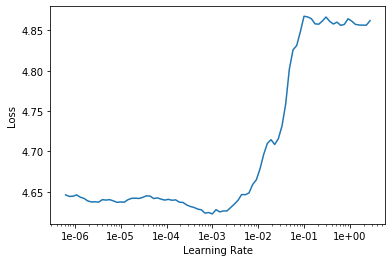

In [85]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,4.632586,4.630196,0.009750,0.990250,00:44
1,4.601214,4.598927,0.012500,0.987500,00:46
2,4.580403,4.579720,0.013917,0.986083,00:46
3,4.572208,4.572018,0.014167,0.985833,00:45
4,4.571839,4.570214,0.014917,0.985083,00:44


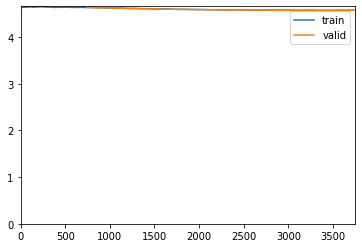

In [86]:
learn.fit_one_cycle(5, 1e-6)

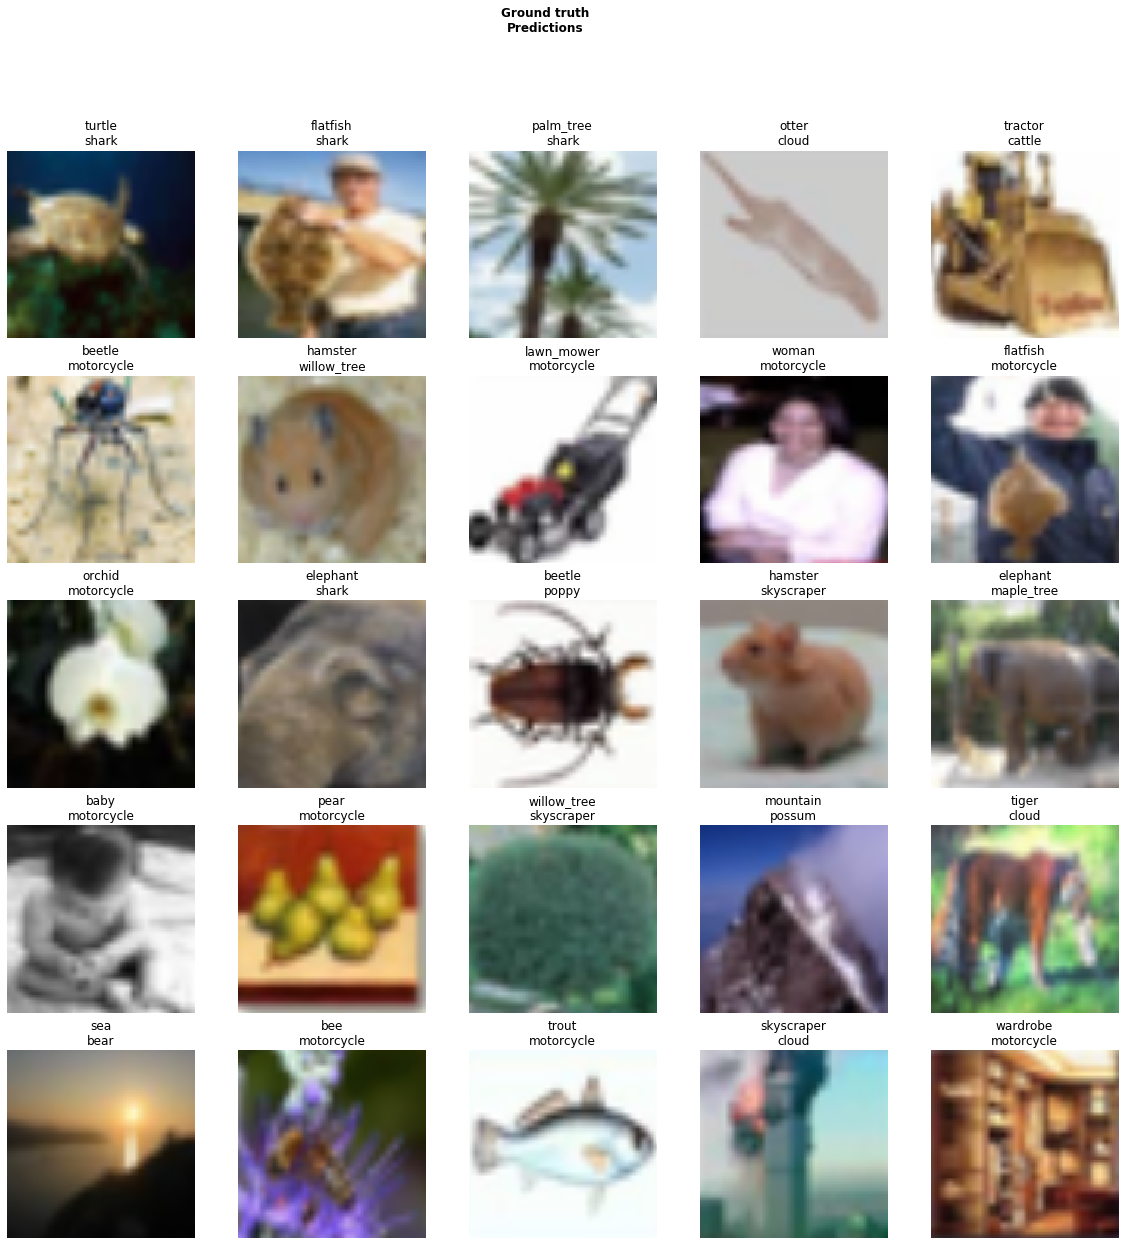

In [80]:
learn.show_results()